# New Horizons launch and trajectory

Main data source: Guo & Farquhar "New Horizons Mission Design" http://www.boulder.swri.edu/pkb/ssr/ssr-mission-design.pdf

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from astropy import time
from astropy import units as u

from poliastro.bodies import Sun, Earth, Jupiter
from poliastro.twobody import Orbit
from poliastro.plotting import plot, OrbitPlotter
from poliastro import iod
from poliastro.util import norm

## Parking orbit

Quoting from "New Horizons Mission Design":

> It was first inserted into an elliptical Earth parking orbit
of **perigee altitude 165 km** and **apogee altitude 215 km**. [Emphasis mine]

<Quantity [ 0.        , 7.81989358, 0.        ] km / s>

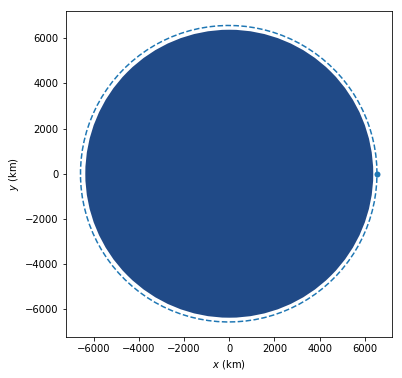

In [2]:
r_p = Earth.R + 165 * u.km
r_a = Earth.R + 215 * u.km

a_parking = (r_p + r_a) / 2
ecc_parking = 1 - r_p / a_parking

parking = Orbit.from_classical(Earth, a_parking, ecc_parking,
                               0 * u.deg, 0 * u.deg, 0 * u.deg, 0 * u.deg,  # We don't mind
                               time.Time("2006-01-19", scale='utc'))

plot(parking)
parking.v

## Hyperbolic exit

Hyperbolic excess velocity:

$$ v_{\infty}^2 = \frac{\mu}{-a} = 2 \varepsilon = C_3 $$

Relation between orbital velocity $v$, local escape velocity $v_e$ and hyperbolic excess velocity $v_{\infty}$:

$$ v^2 = v_e^2 + v_{\infty}^2 $$

### Option a): Insert $C_3$ from report, check $v_e$ at parking perigee

In [3]:
C_3_A = 157.6561 * u.km**2 / u.s**2  # Designed

a_exit = -(Earth.k / C_3_A).to(u.km)
ecc_exit = 1 - r_p / a_exit

exit = Orbit.from_classical(Earth, a_exit, ecc_exit,
                            0 * u.deg, 0 * u.deg, 0 * u.deg, 0 * u.deg,  # We don't mind
                            time.Time("2006-01-19", scale='utc'))

norm(exit.v).to(u.km / u.s)

<Quantity 16.71806884482923 km / s>

Quoting "New Horizons Mission Design":

> After a short coast in the parking orbit, the spacecraft was then injected into
the desired heliocentric orbit by the Centaur second stage and Star 48B third
stage. At the Star 48B burnout, the New Horizons spacecraft reached the highest
Earth departure speed, **estimated at 16.2 km/s**, becoming the fastest spacecraft
ever launched from Earth.  [Emphasis mine]

In [4]:
v_estimated = 16.2 * u.km / u.s

print("Relative error of {:.2f} %".format((norm(exit.v) - v_estimated) / v_estimated * 100))

Relative error of 3.20 %


So it stays within the same order of magnitude. Which is reasonable, because real life burns are not instantaneous.

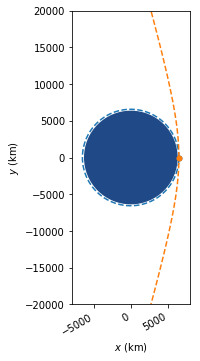

In [5]:
op = OrbitPlotter()

op.plot(parking)
op.plot(exit)

plt.xlim(-8000, 8000)
plt.ylim(-20000, 20000)
plt.gcf().autofmt_xdate()

### Option b): Compute $v_{\infty}$ using the Jupyter flyby

According to Wikipedia, the closest approach occurred at 05:43:40 UTC. We can use this data to compute the solution of the Lambert problem between the Earth and Jupiter.

In [6]:
nh_date = time.Time("2006-01-19 19:00", scale='utc')
nh_flyby_date = time.Time("2007-02-28 05:43:40", scale='utc')
nh_tof = nh_flyby_date - nh_date

nh_earth = Orbit.from_body_ephem(Earth, nh_date)
nh_r_0, v_earth = nh_earth.rv()

nh_jup = Orbit.from_body_ephem(Jupiter, nh_flyby_date)
nh_r_f, v_jup = nh_jup.rv()

(nh_v_0, nh_v_f), = iod.lambert(Sun.k, nh_r_0, nh_r_f, nh_tof)

The hyperbolic excess velocity is measured with respect to the Earth:

In [7]:
C_3_lambert = (norm(nh_v_0 - v_earth)).to(u.km / u.s)**2
C_3_lambert

<Quantity 158.45628219034052 km2 / s2>

In [8]:
print("Relative error of {:.2f} %".format((C_3_lambert - C_3_A) / C_3_A * 100))

Relative error of 0.51 %


Which again, stays within the same order of magnitude of the figure given to the Guo & Farquhar report.

## From Earth to Jupiter

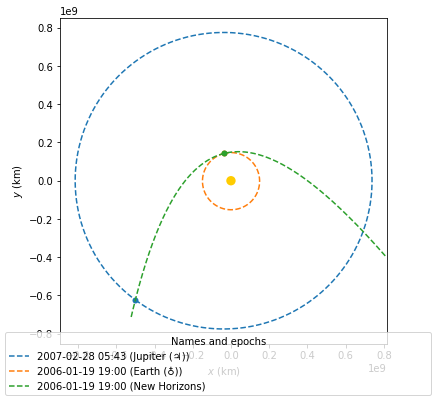

In [9]:
from poliastro.plotting import BODY_COLORS

nh = Orbit.from_vectors(Sun, nh_r_0.to(u.km), nh_v_0.to(u.km / u.s), nh_date)

op = OrbitPlotter(num_points=1000)

op.plot(nh_jup, label=Jupiter)

plt.gca().set_autoscale_on(False)

op.plot(nh_earth, label=Earth)
op.plot(nh, label="New Horizons")